# **UGain ML Tree-based Models Demo Notebook**

## **Import Libraries**

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", DeprecationWarning)

# Sklearn
## Data
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

## Models
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

## Model Explaination
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

## Metrics
from sklearn.metrics import accuracy_score

# XGBoost
import xgboost

# Plotting
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display



## **Load Dataset**

In [ ]:
# Load dataset
breast_cancer_data = load_breast_cancer()
predictors = breast_cancer_data['data']
labels = breast_cancer_data['target']

# Print description of the dataset
print(breast_cancer_data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### **Train - Test Dataset Split**

In [ ]:
# Parameters
seed = 0

# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(predictors, 
                                                    labels, 
                                                    random_state=seed)

## **Decision Tree**

### **Decision Tree with Default Prameters**

In [ ]:
# Create decision tree classifier object
decision_tree_classifier = tree.DecisionTreeClassifier(random_state=seed)

# Fit the training data to the classifier
decision_tree_classifier = decision_tree_classifier.fit(X_train, y_train)

# Calculate accuracy of the train and test sets
train_predictions = decision_tree_classifier.predict(X_train)
test_predictions = decision_tree_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 4),
                                                                      round(accuracy_score(y_test, test_predictions), 4)))

Train set accuracy is: 1.0 and test set accuracy is: 0.8811


### **Decision Trees with Cost Complexity Pruning**

In [ ]:
# Call built-in method to compute the pruning path during Minimal Cost-Complexity Pruning.
path = decision_tree_classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# For every complexity parameter computed (cpp_alpha), fit a decision tree 

## Declare empty lists to store values
train_accuracy_list = []
test_accuracy_list = []
decision_tree_classifier_list = []

## Loop for every cost complexity pruning parameter
for idx, ccp_alpha in enumerate(ccp_alphas):
    ## Declare decision tree with cost complexity parameter
    decision_tree_classifier = tree.DecisionTreeClassifier(random_state=seed, 
                                                           ccp_alpha=ccp_alpha)
    
    ## Fit the decision tree
    decision_tree_classifier.fit(X_train, y_train)

    ## Calculate results and save the fitted decision tree
    train_predictions = decision_tree_classifier.predict(X_train)
    test_predictions = decision_tree_classifier.predict(X_test)
    train_accuracy_list.append(accuracy_score(y_train, train_predictions))
    test_accuracy_list.append(accuracy_score(y_test, test_predictions))
    decision_tree_classifier_list.append(decision_tree_classifier)

    ## Verbose 
    str_text = "Number of nodes in the tree number {}: \t {} \t-> ccp_alpha: {} \t-> train_accuracy: {} \t-> test_accuracy: {}"
    print(str_text.format(idx+1, 
                          decision_tree_classifier.tree_.node_count, 
                          str(round(ccp_alpha, 4)).ljust(6, '0'),
                          str(round(accuracy_score(y_train, train_predictions), 4)).ljust(6, '0'),
                          str(round(accuracy_score(y_test, test_predictions), 4)).ljust(6, '0')))

Number of nodes in the tree number 1: 	 31 	-> ccp_alpha: 0.0000 	-> train_accuracy: 1.0000 	-> test_accuracy: 0.8811
Number of nodes in the tree number 2: 	 27 	-> ccp_alpha: 0.0023 	-> train_accuracy: 0.9977 	-> test_accuracy: 0.8881
Number of nodes in the tree number 3: 	 21 	-> ccp_alpha: 0.0046 	-> train_accuracy: 0.9906 	-> test_accuracy: 0.9161
Number of nodes in the tree number 4: 	 19 	-> ccp_alpha: 0.0047 	-> train_accuracy: 0.9883 	-> test_accuracy: 0.9161
Number of nodes in the tree number 5: 	 17 	-> ccp_alpha: 0.0056 	-> train_accuracy: 0.9836 	-> test_accuracy: 0.9161
Number of nodes in the tree number 6: 	 15 	-> ccp_alpha: 0.0070 	-> train_accuracy: 0.9789 	-> test_accuracy: 0.9231
Number of nodes in the tree number 7: 	 13 	-> ccp_alpha: 0.0078 	-> train_accuracy: 0.9765 	-> test_accuracy: 0.9301
Number of nodes in the tree number 8: 	 11 	-> ccp_alpha: 0.0091 	-> train_accuracy: 0.9718 	-> test_accuracy: 0.9301
Number of nodes in the tree number 9: 	 9 	-> ccp_alpha:

### **Plot: Effect Cost-Complexity Parameter**

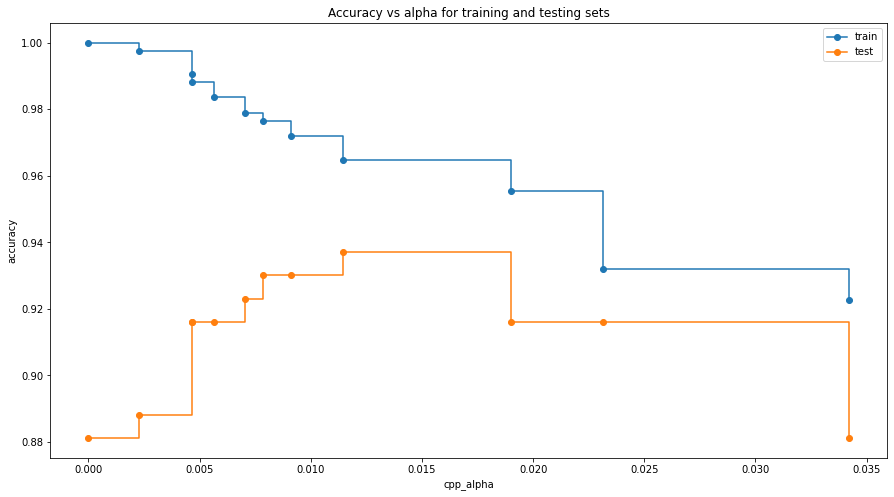

In [ ]:
# Declare figure and set parameters
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel("cpp_alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")

# Plot training data (excluding last cpp_alpha due to very low scores)
ax.plot(ccp_alphas[:-1], train_accuracy_list[:-1], marker="o", label="train", drawstyle="steps-post")

# Plot test data (excluding last cpp_alpha due to very low scores)
ax.plot(ccp_alphas[:-1], test_accuracy_list[:-1], marker="o", label="test", drawstyle="steps-post")

# Display the plot
ax.legend()
plt.show()

### **Decision Tree with Best Cost-Complexity Parameter**

In [ ]:
# Create decision tree classifier object
decision_tree_classifier = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alphas[8])

# Fit the training data to the classifier
decision_tree_classifier = decision_tree_classifier.fit(X_train, y_train)

# Calculate accuracy of the train and test sets
train_predictions = decision_tree_classifier.predict(X_train)
test_predictions = decision_tree_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 4),
                                                                      round(accuracy_score(y_test, test_predictions), 4)))

Train set accuracy is: 0.9648 and test set accuracy is: 0.9371


#### **Plot: Decision Tree with Best Cost-Complexity Parameter**

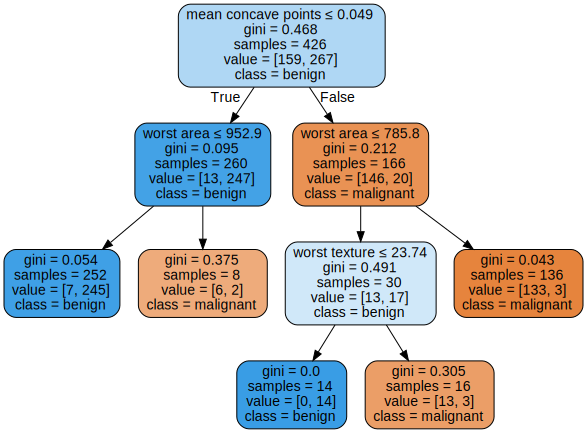

In [ ]:
# Plot the fitted decision tree using GraphViz library
dot_data = tree.export_graphviz(decision_tree_classifier, 
                                feature_names=breast_cancer_data.feature_names,  
                                class_names=breast_cancer_data.target_names,  
                                filled=True, 
                                rounded=True,  
                                special_characters=True)  

# Display the tree plot
display(graphviz.Source(dot_data))

## **Ensemble Learning**

### **Random Forest with Basic Parameters**

In [ ]:
# Create random forest classifier object
random_forest_classifier = ensemble.RandomForestClassifier(warm_start=True,
                                                           oob_score=True,
                                                           max_features='sqrt',
                                                           random_state=seed,)

# Fit the training data to the classifier
random_forest_classifier = random_forest_classifier.fit(X_train, y_train)

# Calculate accuracy of the train and test sets
train_predictions = random_forest_classifier.predict(X_train)
test_predictions = random_forest_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 6),
                                                                      round(accuracy_score(y_test, test_predictions), 6)))

Train set accuracy is: 1.0 and test set accuracy is: 0.972028


### **Plot: Effect Number of Trees and Max Estimator Parameter**

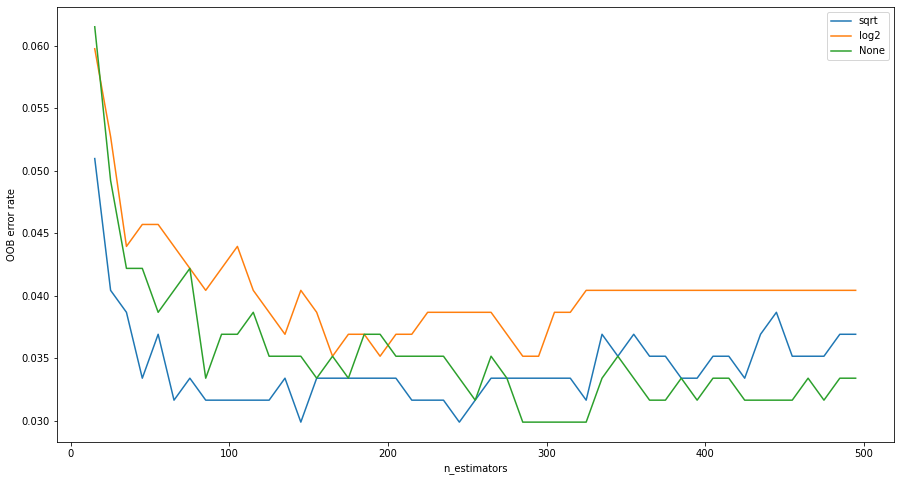

In [ ]:
# Declare function to return random forest classifier with given parameters
def rf_classifier(max_features, seed):
  return ensemble.RandomForestClassifier(warm_start=True,
                                         oob_score=True,
                                         max_features=max_features,
                                         random_state=seed,)

# Declare figure and set labels
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel("n_estimators")
ax.set_ylabel("OOB error rate")

# Loop parameter space of max estimators and number of trees to get out of bag error scores
for max_estimator in ['sqrt', 'log2', None]:
  oob_score_list= []
  random_forest_classifier = rf_classifier(max_estimator, 123)

  for n_estimators in range(15, 501, 10):
    random_forest_classifier.set_params(n_estimators=n_estimators)
    random_forest_classifier = random_forest_classifier.fit(predictors, labels)
    oob_error = 1 - random_forest_classifier.oob_score_
    oob_score_list.append(oob_error)
  ax.plot(list(range(15, 501, 10)), oob_score_list, label=str(max_estimator))

# Display the plot
ax.legend(loc="upper right")
plt.show()

### **Random Forest Hyperparameter Optimization via GridSearchCV**

In [ ]:
# Define parameter space to search
param_grid = { 
    'max_features': ['auto', None],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],}

# Create random forest classifier object
random_forest_classifier = ensemble.RandomForestClassifier(n_estimators=300,
                                                           oob_score=True, 
                                                           n_jobs=-1,
                                                           random_state=seed,) 

# Perform grid search in the defined parameter space with cross validation (3 fold) -> in total 2*3*3*3 = 54 model fits 
CV_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, param_grid=param_grid, cv= 5)
CV_random_forest_classifier.fit(X_train, y_train)
print('Best Parameters:', CV_random_forest_classifier.best_params_)

Best Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2}


#### **Random Forest with Best Parameters**

In [ ]:
# Fit random forest model with best parameters
random_forest_classifier = ensemble.RandomForestClassifier(n_estimators=300,
                                                           oob_score=True, 
                                                           random_state=seed,
                                                           **CV_random_forest_classifier.best_params_,) 
random_forest_classifier = random_forest_classifier.fit(X_train, y_train)

# Calculate accuracy of the best random forest classifier found by grid search
train_predictions = random_forest_classifier.predict(X_train)
test_predictions = random_forest_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 6),
                                                                      round(accuracy_score(y_test, test_predictions), 6)))

Train set accuracy is: 0.992958 and test set accuracy is: 0.972028


### **Plot: Random Forest Classifier Feature Importance**

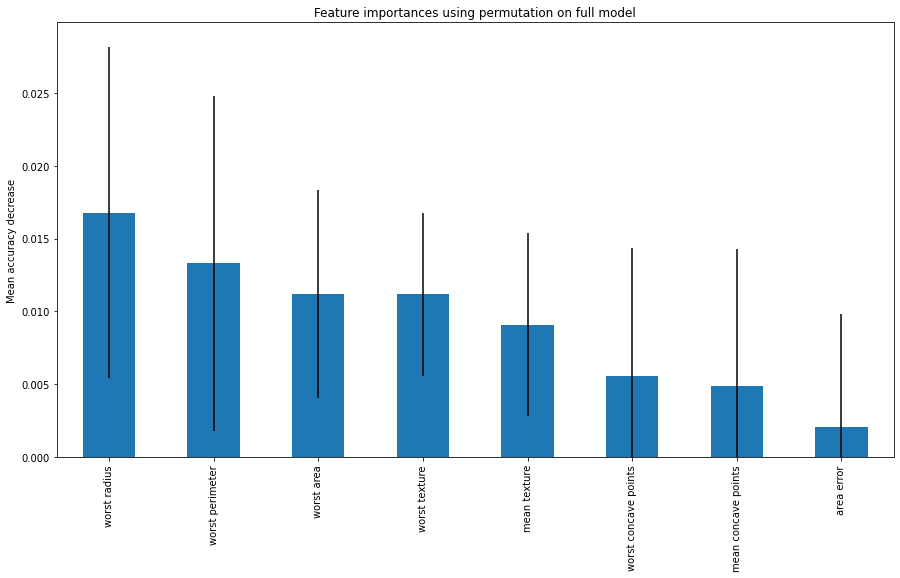

In [ ]:
# Perform permutation feature importance using the best random forest model
permutation_importance_result = permutation_importance(random_forest_classifier, 
                                                       X_test, 
                                                       y_test, 
                                                       n_repeats=10, 
                                                       random_state=seed,)

# Extract the mean and standard deviation of the feature importances from the results and create Pandas Dataframe
forest_importances = pd.DataFrame({"importances" : permutation_importance_result.importances_mean, 
                                   "stdev" : permutation_importance_result.importances_std }, 
                                   index=breast_cancer_data['feature_names']).sort_values("importances", ascending=False).iloc[:8]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(15,8))
forest_importances["importances"].plot.bar(yerr=forest_importances.stdev, ax=ax)
ax.set_title("Feature importances using permutation on test data")
ax.set_ylabel("Mean accuracy decrease")
ax.set_ylim(bottom=0)
plt.show()

### **Plot: Random Forest Classifier Individual Partial Dependence (ICE)**

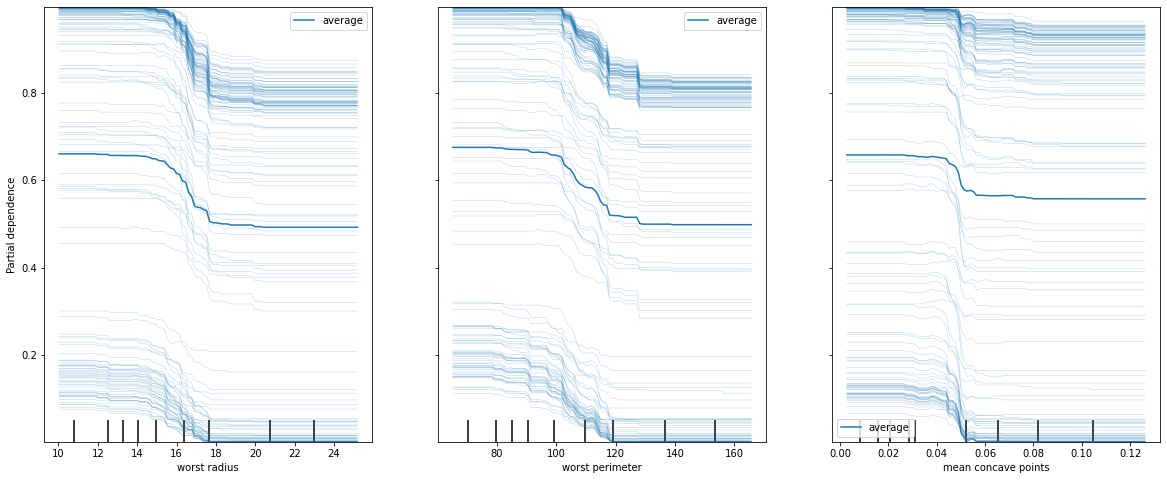

In [ ]:
# Create Pandas DataFrame for the test predictors
X_test_df = pd.DataFrame(X_test, columns=breast_cancer_data['feature_names'])

# Plot individual partial dependency of selected features 
fig, ax = plt.subplots(figsize=(20, 8))
PartialDependenceDisplay.from_estimator(random_forest_classifier, 
                                        X_test_df, 
                                        features = ['worst radius', 'worst perimeter', 'mean concave points'], 
                                        kind='both', 
                                        ax=ax)

### **Gradient Boosting Classifier with Basic Parameters**

In [ ]:
# Create a XGBoost classifier object
gradient_boosting_classifier = ensemble.GradientBoostingClassifier(n_estimators=300, 
                                                                   learning_rate=0.1,
                                                                   max_depth=3, 
                                                                   subsample=1,
                                                                   min_samples_split=2,
                                                                   min_samples_leaf=1,
                                                                   max_features='sqrt',
                                                                   random_state=seed,)

# Fit the training data to the classifier
gradient_boosting_classifier = gradient_boosting_classifier.fit(X_train, y_train)

# Calculate accuracy of the train and test sets
train_predictions = gradient_boosting_classifier.predict(X_train)
test_predictions = gradient_boosting_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 6),
                                                                      round(accuracy_score(y_test, test_predictions), 6)))

Train set accuracy is: 1.0 and test set accuracy is: 0.958042


### **XGBoost with Basic Parameters**

In [ ]:
# Create a XGBoost classifier object
xgboost_classifier = xgboost.XGBClassifier(random_state=seed,)

# Fit the training data to the classifier
xgboost_classifier = xgboost_classifier.fit(X_train, y_train)

# Calculate accuracy of the train and test sets
train_predictions = xgboost_classifier.predict(X_train)
test_predictions = xgboost_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 6),
                                                                      round(accuracy_score(y_test, test_predictions), 6)))

Train set accuracy is: 1.0 and test set accuracy is: 0.979021


### **XGBoost Hyperparameter Optimization via GridSearchCV**

In [ ]:
# Define parameter space to search
param_grid = {
    'max_depth': [2, 3, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 10, 100],
    'colsample_bytree': [0.3, 0.7, 1],
}

# Create XGBoost classifier object
xgboost_classifier = xgboost.XGBClassifier(random_state=seed,)

# Perform grid search in the defined parameter space with cross validation (3 fold) -> in total 3*4*3*3*3 = 324 model fits 
CV_xgboost_classifier = GridSearchCV(estimator=xgboost_classifier, param_grid=param_grid, cv= 5)
CV_xgboost_classifier.fit(X_train, y_train)
print('Best Parameters:', CV_xgboost_classifier.best_params_)

Best Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1}


#### **XGBoost with Best Parameters**

In [ ]:
# Fit XGBoost model with best parameters
xgboost_classifier = xgboost.XGBClassifier(**CV_xgboost_classifier.best_params_) 
xgboost_classifier = xgboost_classifier.fit(X_train, y_train)

# Calculate accuracy of the best XGBoost classifier found by grid search
train_predictions = xgboost_classifier.predict(X_train)
test_predictions = xgboost_classifier.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 6),
                                                                      round(accuracy_score(y_test, test_predictions), 6)))

Train set accuracy is: 1.0 and test set accuracy is: 0.986014


### **Isolation Forest**

(array([  0,   3,   9,  12,  25,  38,  42,  68,  71,  78,  82,  83, 101,
       108, 112, 116, 122, 151, 152, 176, 180, 181, 190, 192, 202, 212,
       213, 219, 236, 252, 258, 265, 272, 290, 314, 318, 323, 339, 351,
       352, 368, 369, 376, 379, 400, 461, 503, 504, 505, 521, 539, 561,
       562, 563, 564, 567]),)


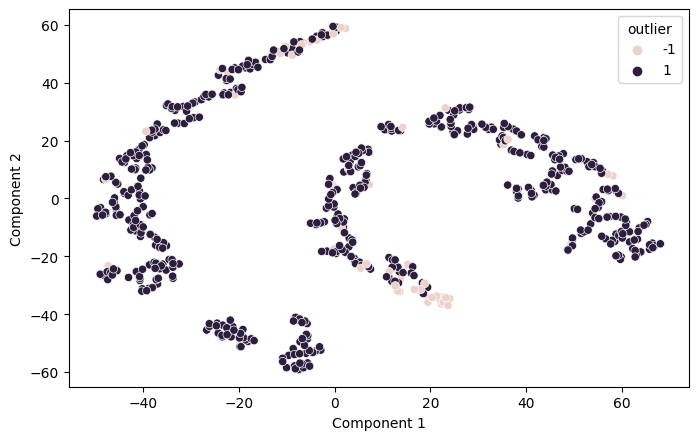

In [ ]:
# Create Pandas DataFrame from the predictor array
predictor_df = pd.DataFrame(predictors, columns=breast_cancer_data['feature_names'])

# Use T-distributed Stochastic Neighbor Embedding (TSNE) for creating low ddimensional embeddings (visualization purposes)
predictor_embedded = TSNE(n_components=2, 
                          learning_rate=200,
                          init='random', 
                          perplexity=10,
                          random_state=seed,).fit_transform(predictor_df)

predictor_embedded_df = pd.DataFrame(predictor_embedded, columns=['Component 1', 'Component 2'])

# Fit and predict isolation forest model
outliers = ensemble.IsolationForest(n_estimators=1000, bootstrap=False, random_state=seed,).fit_predict(predictor_df)

# Assign the outlier labels as a column to the Pandas DataFrame
predictor_embedded_df['outlier'] = outliers
predictor_embedded_df['outlierx'] = predictor_embedded_df['outlier'].astype(str) + ' ' + pd.Series().astype(str)

# Verbose the outlying cases indices and plot using 2 variables (outlier are marked as -1 and normal as 1)
print(np.where(outliers == -1))
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
sns.scatterplot(x='Component 1', 
                y='Component 2', 
                hue='outlier', 
                data=predictor_embedded_df)

## **AutoML**

In [ ]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 260 kB 48.6 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 4.3 MB 31.1 MB/s 
     |████████████████████████████████| 4.4 MB 63.9 MB/s 
     |████████████████████████████████| 46 kB 2.4 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641946 sha256=e70d6c90bd39dc5aba9b2a82b1966dc8b211b4e25844f573e44510a616f06c6a
  Stored in directory: /root/.cache/pip/wheels/26/57/ce/ca63ad74b90273f9a682028d187645a42dce5c5255228d46c8
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7043 sha256=ae3f6f27833b7129f2e8991d158326273db40a57e6ebfb5d83a4f6fe576434a9
  Sto

In [ ]:
# Import Auto-Sklearn (Run Twice!)
import autosklearn.classification

In [ ]:
# Define AutoML classification model from Auto-Sklearn
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=180)

# Fit AutoML classification model 
automl.fit(X_train, y_train)

# Calculate accuracy of the train and test sets
train_predictions = automl.predict(X_train)
test_predictions = automl.predict(X_test)
print("Train set accuracy is: {} and test set accuracy is: {}".format(round(accuracy_score(y_train, train_predictions), 6),
                                                                      round(accuracy_score(y_test, test_predictions), 6)))

Train set accuracy is: 0.995305 and test set accuracy is: 0.993007


In [ ]:
# Verbose Final Model Leaderboard from AutoML
print(automl.leaderboard())

          rank  ensemble_weight                 type      cost  duration
model_id                                                                
4            1             0.08                  mlp  0.014184  2.380415
30           2             0.06                  mlp  0.014184  1.522509
17           3             0.06                  mlp  0.021277  5.856078
20           4             0.02                  mlp  0.021277  2.828502
3            6             0.04                  mlp  0.028369  1.321686
42           7             0.06                  mlp  0.028369  1.239870
44           5             0.02                  mlp  0.028369  1.789408
19           9             0.04          extra_trees  0.035461  3.419016
24          10             0.06        random_forest  0.035461  2.017286
34           8             0.02    gradient_boosting  0.035461  1.660724
7           11             0.02        random_forest  0.042553  2.335268
9           12             0.06        random_fores